In [21]:
import os
import gc
import math

# numpy
import numpy as np
import numpy.ma as ma

from jax import vmap, grad, jit, random
from jax.config import config
# from jax.experimental import optimizers
import jax.numpy as jnp
from jax.tree_util import tree_map, tree_flatten, tree_unflatten, tree_leaves

config.update("jax_enable_x64", True)

from skimage.restoration import estimate_sigma
from skimage.transform import resize

### CRPS
import properscoring as ps

### SSIM and PSNR
from skimage.metrics import structural_similarity as ssim
from skimage.metrics import peak_signal_noise_ratio as psnr

# plotting
import matplotlib
import matplotlib.pyplot as plt
from matplotlib import ticker
from matplotlib.ticker import FormatStrFormatter
plt.style.use('default')

from matplotlib.gridspec import GridSpec
from matplotlib import colors
from cartopy import config
import cartopy.crs as ccrs
import cartopy.feature as cfeature

from matplotlib import cm
from matplotlib.colors import ListedColormap, LinearSegmentedColormap

# netCDF
import netCDF4 as nc

from tqdm.notebook import tqdm
from tqdm.notebook import trange

from scipy.stats import norm

import pickle

In [8]:
nfit = 789
nval = 9
pred_int = 70
nmod = 16
nlat = 721
nlon = 1440

scale = np.cos(np.linspace(math.pi/2, -math.pi/2, nlat))
scale /= np.mean(scale)

In [9]:
nngp = np.load('./tas_predictions/nngp_pred.npy', mmap_mode = 'r')
ens = np.load('./tas_predictions/lm_pred.npy', mmap_mode = 'r')[nval:]

In [10]:
### TAS
nngp = np.load('./tas_predictions/nngp_pred.npy', mmap_mode = 'r')
lm = np.load('./tas_predictions/lm_pred.npy', mmap_mode = 'r')[nval:]
ens = np.load('./tas_predictions/ens_pred.npy', mmap_mode = 'r')[nval:]

nngp_yr = np.array([np.mean(nngp[(i*12):((i+1)*12)] * scale[None,:,None], axis = 0) for i in range(85)])
lm_yr = np.array([np.mean(lm[(i*12):((i+1)*12)] * scale[None,:,None], axis = 0) for i in range(85)])
ens_yr = np.array([np.mean(ens[(i*12):((i+1)*12)] * scale[None,:,None], axis = 0) for i in range(85)])

nngp_dec = np.array([np.mean(nngp_yr[(i*20):((i+1)*20)], axis = 0) for i in range(5)])
nngp_dec = nngp_dec[0:4]
nngp_tas = nngp_dec
# nngp_tas = np.array([x - nngp_dec[0] for x in nngp_dec])

lm_dec = np.array([np.mean(lm_yr[(i*20):((i+1)*20)], axis = 0) for i in range(5)])
lm_dec = lm_dec[0:4]
lm_tas = lm_dec

ens_dec = np.array([np.mean(ens_yr[(i*20):((i+1)*20)], axis = 0) for i in range(5)])
ens_dec = ens_dec[0:4]
ens_tas = ens_dec
# ens_tas = np.array([x - ens_dec[0] for x in ens_dec])


### PR
nngp = np.load('./pr_predictions/nngp_pred.npy', mmap_mode = 'r')
lm = np.load('./pr_predictions/lm_pred.npy', mmap_mode = 'r')[nval:]
ens = np.load('./pr_predictions/ens_pred.npy', mmap_mode = 'r')[nval:]

nngp_yr = np.array([np.mean(nngp[(i*12):((i+1)*12)] * scale[None,:,None], axis = 0) for i in range(85)])
lm_yr = np.array([np.mean(lm[(i*12):((i+1)*12)] * scale[None,:,None], axis = 0) for i in range(85)])
ens_yr = np.array([np.mean(ens[(i*12):((i+1)*12)] * scale[None,:,None], axis = 0) for i in range(85)])

nngp_dec = np.array([np.mean(nngp_yr[(i*20):((i+1)*20)], axis = 0) for i in range(5)])
nngp_dec = nngp_dec[0:4]
nngp_pr = nngp_dec
# nngp_pr = np.array([x - nngp_dec[0] for x in nngp_dec])

lm_dec = np.array([np.mean(lm_yr[(i*20):((i+1)*20)], axis = 0) for i in range(5)])
lm_dec = lm_dec[0:4]
lm_pr = lm_dec
# nngp_pr = np.array([x - nngp_dec[0] for x in nngp_dec])

ens_dec = np.array([np.mean(ens_yr[(i*20):((i+1)*20)], axis = 0) for i in range(5)])
ens_dec = ens_dec[0:4]
ens_pr = ens_dec
# ens_pr = np.array([x - ens_dec[0] for x in ens_dec])

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

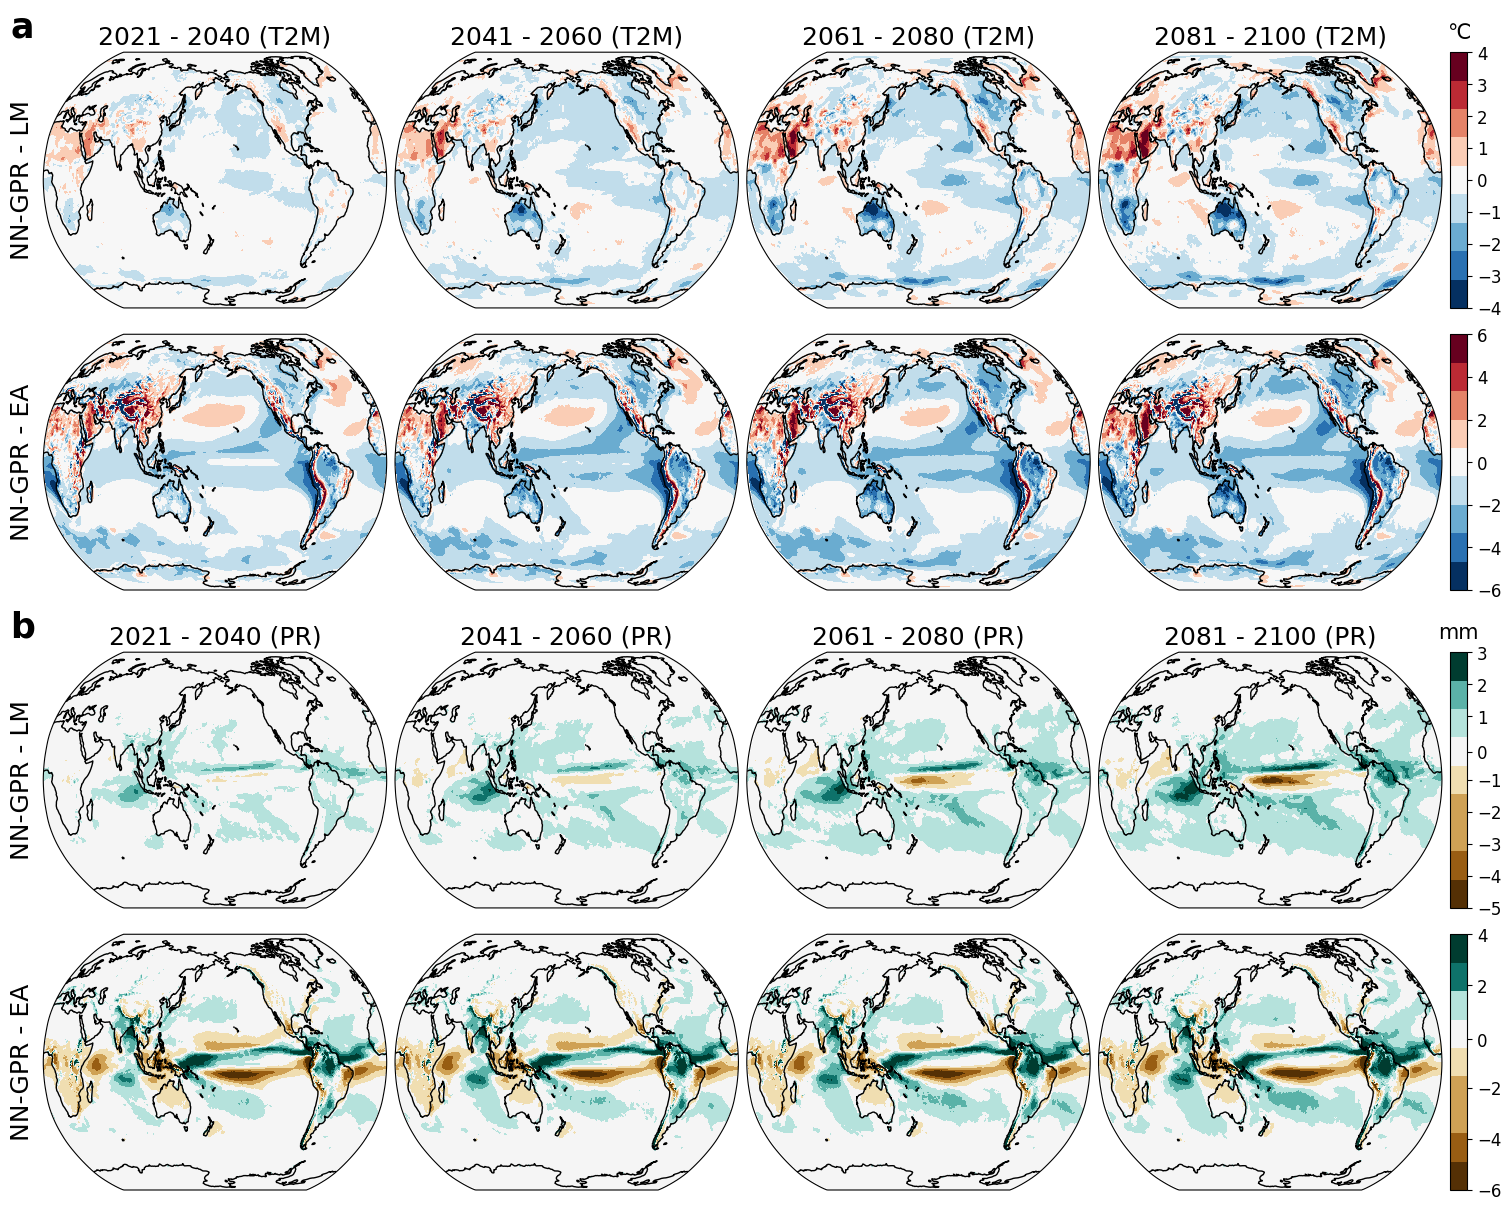

In [11]:
data_crs = ccrs.PlateCarree(central_longitude=180)
plot_crs = ccrs.Robinson(central_longitude=180)

fig = plt.figure(constrained_layout = True, figsize = (15, 12))
gs = GridSpec(4, 6, width_ratios = [0.05, 1, 1, 1, 1, 0.05], figure = fig)

times = ['2021 - 2040', '2041 - 2060', '2061 - 2080', '2081 - 2100']

### temperatures
ax = plt.subplot(gs[0, 0])
ax.axis('off')
ax.text(0.0, 0.5, 'NN-GPR - LM', rotation=90, va='center', fontsize=18)
ax.text(0.0, 1.1, 'a', va='center', fontsize=25, fontweight='bold')
divnorm = colors.TwoSlopeNorm(vmin=-4, vcenter=0, vmax=4)
cmap = plt.get_cmap('RdBu_r', 9)
for i in trange(1, 5, leave = False):
    ax = plt.subplot(gs[0, i], projection=plot_crs)
    im = ax.imshow(nngp_tas[i-1] - lm_tas[i-1], cmap = cmap, norm = divnorm, transform = data_crs)
    ax.coastlines()
    ax.set_aspect('auto', adjustable=None)
    ax.set_title(f'{times[i-1]} (T2M)', fontsize = 18)
    
ax = plt.subplot(gs[0, 5])
cbar = plt.colorbar(im, cax=ax)
cbar.ax.tick_params(labelsize=12)
cbar.ax.set_title('\u2103', fontsize = 15, pad = 10)
    
ax = plt.subplot(gs[1, 0])
ax.axis('off')
ax.text(0.0, 0.5, 'NN-GPR - EA', rotation=90, va='center', fontsize=18)
divnorm = colors.TwoSlopeNorm(vmin=-6, vcenter=0, vmax=6)
for i in trange(1, 5, leave = False):
    ax = plt.subplot(gs[1, i], projection=plot_crs)
    im = ax.imshow(nngp_tas[i-1] - ens_tas[i-1], cmap = cmap, norm = divnorm, transform = data_crs)
    ax.coastlines()
    ax.set_aspect('auto', adjustable=None)
#     ax.set_title(f'{2020 + 10*(2*(i-1))} - {2020 + 10*(2*(i-1)+2)} (T2M)', fontsize = 15)
    
ax = plt.subplot(gs[1, 5])
cbar = plt.colorbar(im, cax=ax)
cbar.ax.tick_params(labelsize=12)
# cbar.ax.set_title('\u2103', fontsize = 15, pad = 10)



### preciptation
ax = plt.subplot(gs[2, 0])
ax.axis('off')
ax.text(0.0, 0.5, 'NN-GPR - LM', rotation=90, va='center', fontsize=18)
ax.text(0.0, 1.1, 'b', va='center', fontsize=25, fontweight='bold')
divnorm = colors.TwoSlopeNorm(vmin=-5, vcenter=0, vmax=3)
cmap = plt.get_cmap('BrBG', 9)
for i in trange(1, 5, leave = False):
    ax = plt.subplot(gs[2, i], projection=plot_crs)
    im = ax.imshow(nngp_pr[i-1] - lm_pr[i-1], cmap = cmap, norm = divnorm, transform = data_crs)
    ax.coastlines()
    ax.set_aspect('auto', adjustable=None)
    ax.set_title(f'{times[i-1]} (PR)', fontsize = 18)

ax = plt.subplot(gs[2, 5])
cbar = plt.colorbar(im, cax=ax)
cbar.ax.tick_params(labelsize=12)
cbar.ax.set_title('mm', fontsize = 15, pad = 10)
    
ax = plt.subplot(gs[3, 0])
ax.axis('off')
ax.text(0.0, 0.5, 'NN-GPR - EA', rotation=90, va='center', fontsize=18)
divnorm = colors.TwoSlopeNorm(vmin=-6, vcenter=0, vmax=4)
for i in trange(1, 5, leave = False):
    ax = plt.subplot(gs[3, i], projection=plot_crs)
    im = ax.imshow(nngp_pr[i-1] - ens_pr[i-1], cmap = cmap, norm = divnorm, transform = data_crs)
    ax.coastlines()
    ax.set_aspect('auto', adjustable=None)
#     ax.set_title(f'{2020 + 10*(2*(i-1))} - {2020 + 10*(2*(i-1)+2)} (PR)', fontsize = 15)

ax = plt.subplot(gs[3, 5])
cbar = plt.colorbar(im, cax=ax)
cbar.ax.tick_params(labelsize=12)
# cbar.ax.set_title('mm/day', fontsize = 15, pad = 10)

plt.show()